In [1]:
import pandas as pd
import numpy as np
import os
import scipy
from scipy.interpolate import griddata
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.functional import mse_loss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from compute_distance import compute_distance

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(f"Using device: {device}")

h_nD = 30
h_n = 20
input_n = 3
learning_rate = 1e-3

class Swish(nn.Module):
    def __init__(self, inplace=True):
        super(Swish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        if self.inplace:
            x.mul_(torch.sigmoid(x))
            return x
        else:
            return x * torch.sigmoid(x)


class Net1(nn.Module):

    #The __init__ function stack the layers of the 
    #network Sequentially 
    def __init__(self):
        super(Net1, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),

            nn.Linear(h_n,1),
        )
    #This function defines the forward rule of
    #output respect to input.
    def forward(self,x):
        output = self.main(x)
        return  output

class Net2(nn.Module):

    #The __init__ function stack the layers of the 
    #network Sequentially 
    def __init__(self):
        super(Net2, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),

            nn.Linear(h_n,1),
        )
    #This function defines the forward rule of
    #output respect to input.
    def forward(self,x):
        output = self.main(x)
        return  output

class Net3(nn.Module):

    #The __init__ function stack the layers of the 
    #network Sequentially 
    def __init__(self):
        super(Net3, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            nn.Linear(h_n,h_n),
            #nn.Tanh(),
            #nn.Sigmoid(),
            Swish(),
            ################## below are added layers

            nn.Linear(h_n,1),
        )
    #This function defines the forward rule of
    #output respect to input.
    def forward(self,x):
        output = self.main(x)
        return  output

Using device: cuda


In [3]:
#Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = torch.tensor(data[:, [0, 1, 5, 7]], dtype=torch.float32).to(device)
        self.targets = torch.tensor(data[:, [2, 3, 4]], dtype=torch.float32).to(device)


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [4]:
def initialize_models():
    # Move models to GPU
    model_1 = Net1().to(device)
    model_2 = Net2().to(device)
    model_3 = Net3().to(device)

    print(f"Model_1 is on: {next(model_1.parameters()).device}")
    print(f"Model_2 is on: {next(model_2.parameters()).device}")
    print(f"Model_3 is on: {next(model_3.parameters()).device}")


    optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
    optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
    optimizer_3 = optim.Adam(model_3.parameters(), lr=1e-3)

    return model_1, model_2, model_3, optimizer_1, optimizer_2, optimizer_3

In [5]:
model_1, model_2, model_3, optimizer_1, optimizer_2, optimizer_3 = initialize_models()
# Load model parameters with `weights_only=True`

e_idx = 453
mode = "label_free"

model_1.load_state_dict(torch.load(f"models/{mode}/{mode}_1_epoch_{e_idx}.pth", weights_only=True))
model_2.load_state_dict(torch.load(f"models/{mode}/{mode}_2_epoch_{e_idx}.pth", weights_only=True))
model_3.load_state_dict(torch.load(f"models/{mode}/{mode}_3_epoch_{e_idx}.pth", weights_only=True))

# Set models to evaluation mode
model_1.eval()
model_2.eval()
model_3.eval()


Model_1 is on: cuda:0
Model_2 is on: cuda:0
Model_3 is on: cuda:0


Net3(
  (main): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Swish()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Swish()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Swish()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [6]:
import os
import pandas as pd
import torch
import numpy as np

# Folder path containing CSV files
folder_path = "data/csv"

# Define value ranges
first_values = np.arange(0.3, 0.7, 0.05)  # 0.25 to 0.7 with step 0.05
# second_values = np.arange(3, 15, 1)  # 3 to 14
second_values = [10]

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Iterate over all possible files
for first in first_values:
    for second in second_values:
        first_str = f"{first:.2f}".rstrip("0").rstrip(".")
        file_name = f"W_{first_str}_{second}_1.csv"
        file_path = os.path.join(folder_path, file_name)
        
        if os.path.exists(file_path):
            print(f"Processing {file_name}...")
            
            # Load CSV file
            df = pd.read_csv(file_path)
            
            # Extract input and output data
            input_data = df.iloc[:, [0, 1, 5]].values  # (x, y, d, N) [0, 1, 5, 7]
            output_data = df.iloc[:, [2, 3, 4]].values  # (u, v, p)
            
            input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

            # Extract individual elements
            x, y, d = input_tensor[:, 0], input_tensor[:, 1], input_tensor[:, 2]
            x = x.unsqueeze(-1)  # Shape (B, 1)
            y = y.unsqueeze(-1)  # Shape (B, 1)
            d = d.unsqueeze(-1)
            
            # n = input_tensor[:, 3]
            n = torch.full_like(x, 10)  # Assuming n is constant for this example
            
            # Predict using trained models
            with torch.no_grad():
                u_pred = model_1(input_tensor)
                v_pred = model_2(input_tensor)
                p_pred = model_3(input_tensor)
            
            # Apply conditions
            v_pred[x == 0] = 0  # If x = 0, set v_pred to zero
            
            # Compute distance
            distances = compute_distance(x, y, d, n)
            
            # If distance is zero, set u and v to zero
            mask = distances == 0
            u_pred[mask] = 0
            v_pred[mask] = 0
            
            # Convert to NumPy
            u_pred = u_pred.cpu().numpy()
            v_pred = v_pred.cpu().numpy()
            p_pred = p_pred.cpu().numpy()
            
            # Prepare DataFrame for output
            df_output = pd.DataFrame({
                'x': input_data[:, 0],
                'y': input_data[:, 1],
                'u': u_pred.flatten(),
                'v': v_pred.flatten(),
                'p': p_pred.flatten()
            })
            
            # Save velocity output file
            output_file = f"test_{mode}_{e_idx}_{first_str}_{second}_1.csv"
            output_path = os.path.join(fr"results\{mode}\csv", output_file)
            df_output.to_csv(output_path, index=False)
            print(f"Saved {output_file} successfully!")

print("Processing complete!")

Processing W_0.3_10_1.csv...
Saved test_label_free_453_0.3_10_1.csv successfully!
Processing W_0.35_10_1.csv...
Saved test_label_free_453_0.35_10_1.csv successfully!
Processing W_0.4_10_1.csv...
Saved test_label_free_453_0.4_10_1.csv successfully!
Processing W_0.45_10_1.csv...
Saved test_label_free_453_0.45_10_1.csv successfully!
Processing W_0.5_10_1.csv...
Saved test_label_free_453_0.5_10_1.csv successfully!
Processing W_0.55_10_1.csv...
Saved test_label_free_453_0.55_10_1.csv successfully!
Processing W_0.6_10_1.csv...
Saved test_label_free_453_0.6_10_1.csv successfully!
Processing W_0.65_10_1.csv...
Saved test_label_free_453_0.65_10_1.csv successfully!
Processing complete!


In [7]:
import pandas as pd
import torch
import numpy as np

# File path
file_path = "data/csv/W_0.6_10_1.csv"
file_pat = f"results/{mode}/csv/test_{mode}_{e_idx}_0.6_10_1.csv"
# Load CSV file
df = pd.read_csv(file_path)
dff = pd.read_csv(file_pat)

# Ensure the correct columns are selected for input
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d, N)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

# Ensure the correct columns are selected for input
input_dataf = dff.iloc[:, [0, 1]].values  # Selecting columns (x, y, d, N)
output_dataf = dff.iloc[:, [2, 3]].values  # Selecting columns (u, v, p)

x_grid = input_data[:, 0].reshape(-1)
y_grid = input_data[:, 1].reshape(-1)
v_actual_grid = output_data[:, 1].reshape(-1)
v_pred_grid = output_dataf[:, 1].reshape(-1)
u_actual_grid = output_data[:, 0].reshape(-1)
u_pred_grid = output_dataf[:, 0].reshape(-1)


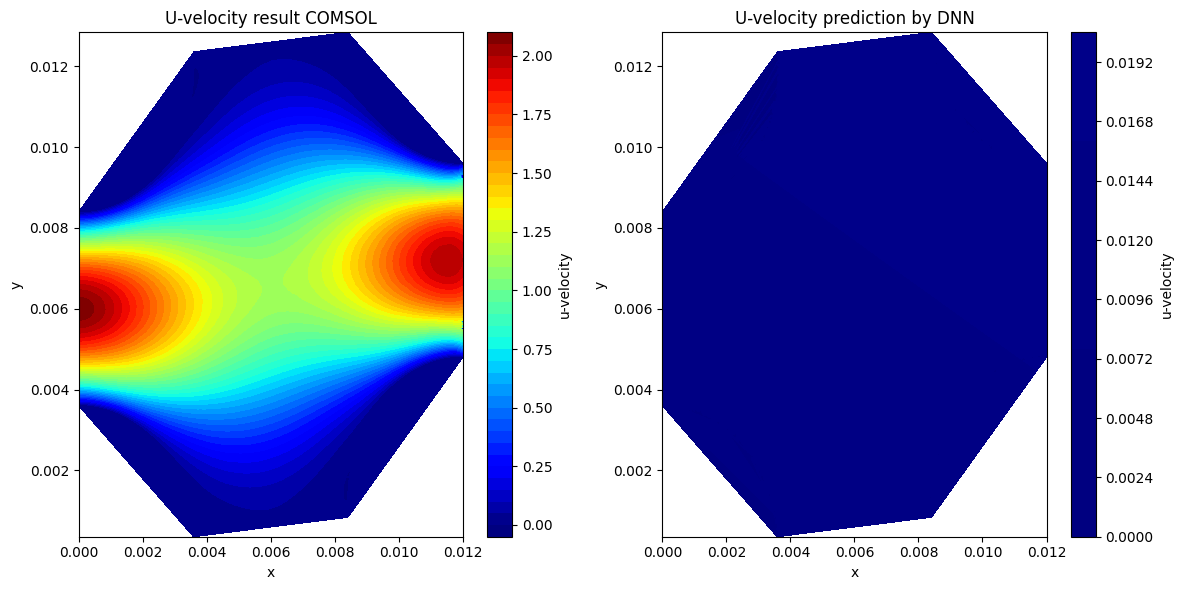

In [8]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(u_actual_grid.min(), u_pred_grid.min())
vmax = max(u_actual_grid.max(), u_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, u_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('U-velocity result COMSOL')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, u_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('U-velocity prediction by DNN')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/{mode}/PIDNN_U_{mode}_{e_idx}_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()


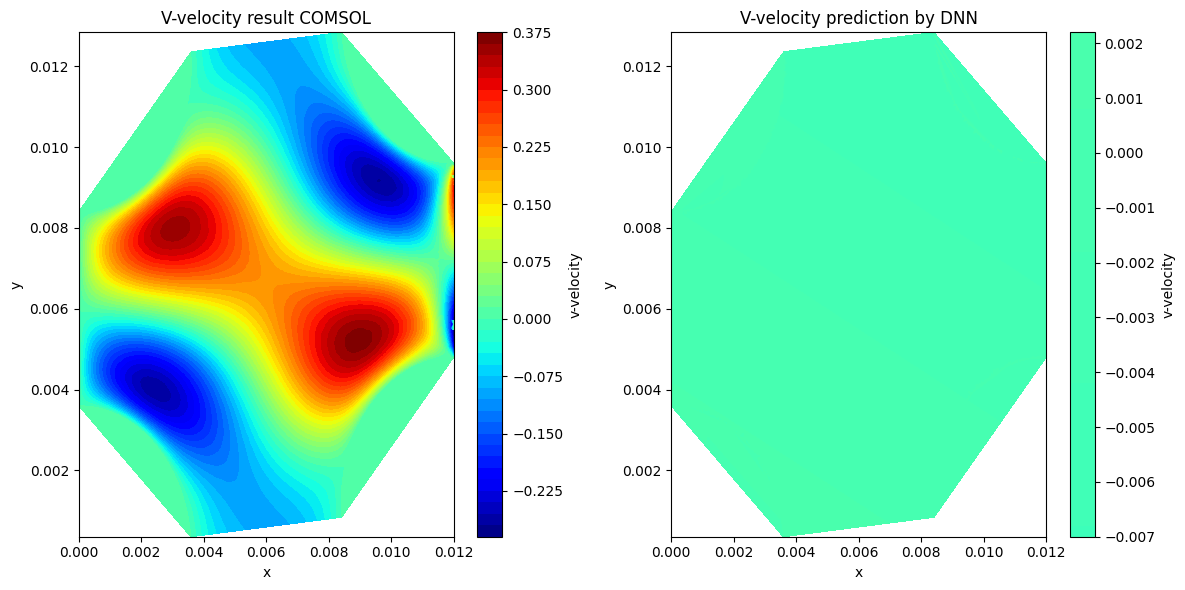

In [9]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='v-velocity')
plt.title('V-velocity result COMSOL')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='v-velocity')
plt.title('V-velocity prediction by DNN')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()

# Save the figure
plt.savefig(f"results/{mode}/PIDNN_V_{mode}_{e_idx}_comparison.png", dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
plt.show()


In [10]:
# Compute MSE using NumPy
mse_u = np.mean((v_pred_grid - v_actual_grid)**2)
print(f"Mean Squared Error for u-component: {mse_u}")

Mean Squared Error for u-component: 0.020343397839612056


In [11]:
# Compute MSE using NumPy
mse_u = np.mean((u_pred_grid - u_actual_grid)**2)
print(f"Mean Squared Error for u-component: {mse_u}")

Mean Squared Error for u-component: 0.7506831113194393
